In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import sys
SRC_DIR = '../'
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

In [22]:
import conceptlab as clab
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import anndata as ad
import scanpy as sc
import torch
from omegaconf import OmegaConf

import pytorch_lightning as pl
from lightning.pytorch.loggers import WandbLogger
import wandb

### Configure Analysis

In [23]:
DATA_PATH = '../../data/hbca_immune/immune_curated.h5ad'
MODEL_PATH = '../../results/model_params/hbca_immune_model.pth'

In [24]:
USE_SAVED_MODEL = True
OVERWRITE_SAVED_MODEL = False

In [25]:
adata = ad.read_h5ad(DATA_PATH)

### Dataset Stats


In [26]:
adata

AnnData object with n_obs × n_vars = 25382 × 16918
    obs: 'sampleID', 'sample_type_coarse', 'sample_type', 'processing_date', 'dissociation_minutes', 'parity', 'brca_status', 'condition', 'tissue_condition', 'reported_ethnicity', 'BMI', 'prob_spikein', 'prob_spikein_dblt', 'pred_spikein', 'n_genes', 'percent_mito', 'n_counts', 'level0_global', 'level1_global', 'level0', 'level1', 'level2', 'scrublet_score', 'scrublet_cluster_score', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'donor_age', 'risk_status', 'is_primary_data', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', '

In [27]:
n_obs,n_concepts = adata.obsm['concepts_soft'].shape
n_samples = adata.obs['sampleID'].unique().shape[0]
n_types = adata.obs['cell_type'].unique().shape[0]

print('cells: {}'.format(n_obs))
print('concepts: {}'.format(n_concepts))
print('samples: {}'.format(n_samples))
print('cell types: {}'.format(n_types))

cells: 25382
concepts: 86
samples: 113
cell types: 15


Filter cells

In [28]:
sc.pp.filter_genes(adata, min_cells= 0.01)
sc.pp.filter_genes(adata, min_counts= 200)

Normalize Data

In [29]:
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)

Plot cellxgene umap data, this will be different from ours later on

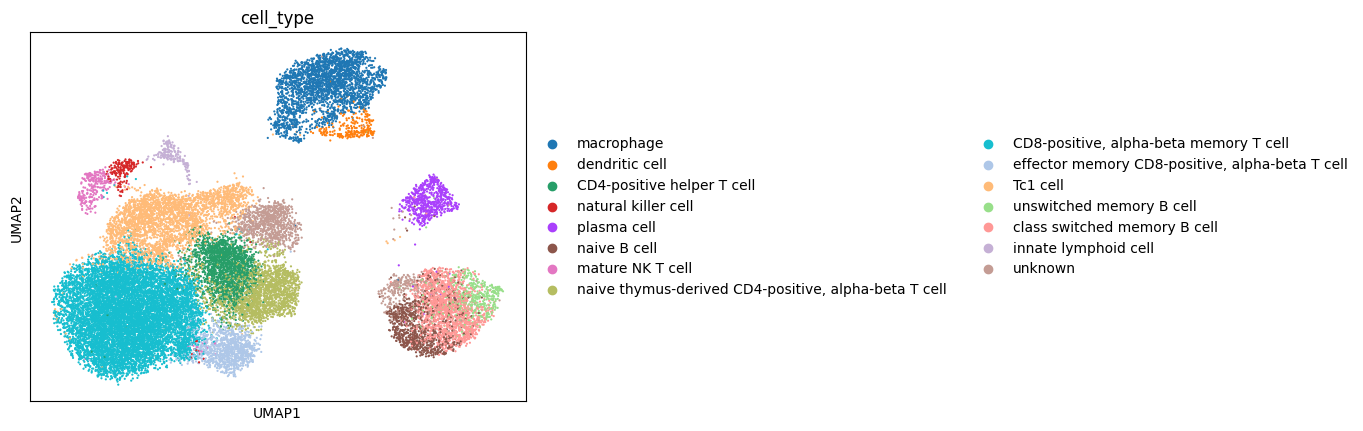

In [30]:
sc.pl.umap(adata, color= 'cell_type', size = 10)

Inspect concepts

/tmp/ipykernel_803979/3085203759.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


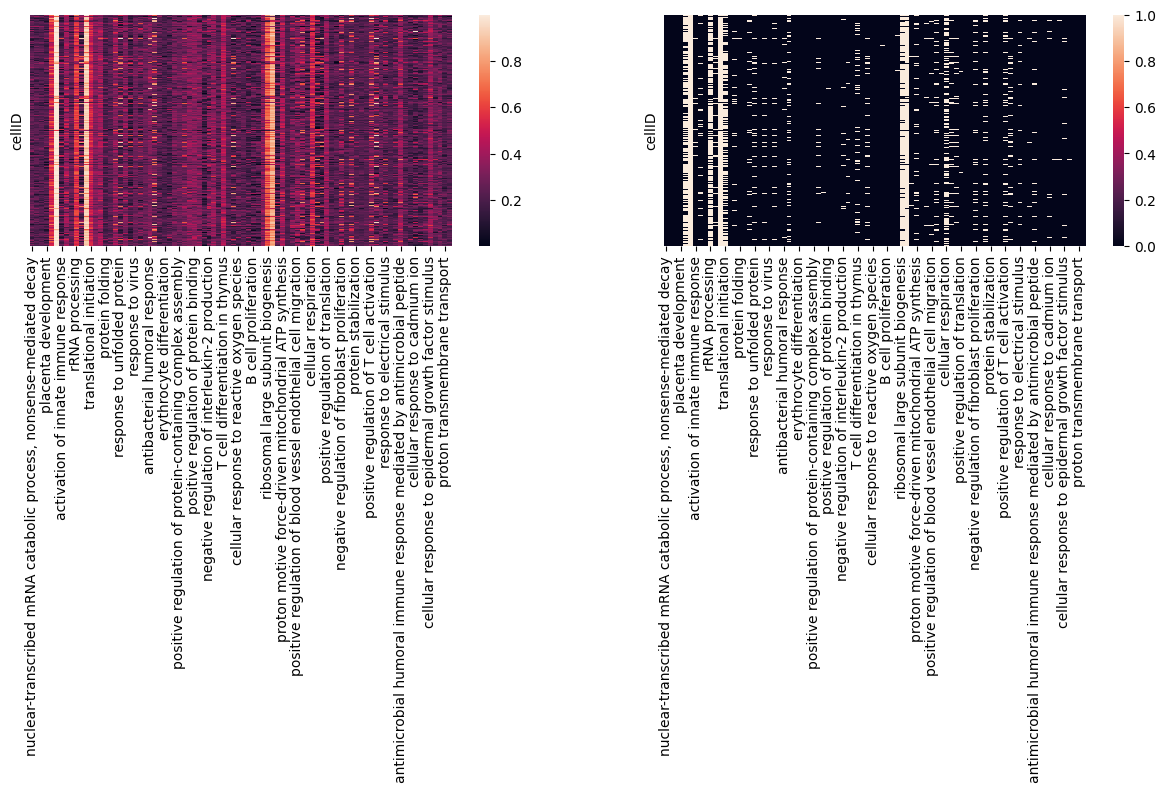

In [31]:
fig,ax = plt.subplots(1,2, figsize = ( 15, 3))
sns.heatmap(adata.obsm['concepts_soft'], ax = ax[0])
sns.heatmap(adata.obsm['concepts_hard'], ax = ax[1])
for axx in ax:
    axx.set_yticks([])
fig.tight_layout()
plt.show()

### Analysis Setup

In [32]:
concept_key = 'concepts_soft'

Set random seed

In [33]:
np.random.seed(69)
torch.manual_seed(69)

Set model config

In [35]:
n_concepts = adata.obsm[concept_key].shape[1]

config_dict = dict(has_cbm = True, 
                   lr = 5e-4,
                   hidden_dim = 128,
                   beta = 1e-5,
                   input_dim = adata.shape[1],
                   latent_dim = 64,
                   n_concepts = n_concepts,
                   min_bottleneck_size = 8, # important
                   independent_training = True,
                   concepts_hp = 0.005,
                   orthogonality_hp = 1, # important
                   use_soft_concepts = True,
                  )

config = OmegaConf.create(config_dict)

model = clab.models.scCBGM(config)

Define train test split

In [36]:
p_test = 0.2
n_test = int(len(adata) * p_test)
n_train = len(adata) - n_test

Get split idxs

In [37]:
ixs = np.arange(len(adata))
np.random.shuffle(ixs)
train_idx = ixs[0:n_train]
test_idx = ixs[n_train::]

Split data

In [38]:
adata_train, adata_test = adata[train_idx].copy(), adata[test_idx].copy()

Create dataset

In [39]:
data_module = clab.data.dataloader.GeneExpressionDataModule(
        adata_train,
        add_concepts=True,
        concept_key=concept_key,
        batch_size=512,
        normalize=False,
    )

Setup logger

In [40]:
if not USE_SAVED_MODEL:
    wandb_logger = WandbLogger(
            project='pathway_demo_001',
            log_model=False,
        )

Setup Trainer

In [41]:
if not USE_SAVED_MODEL:
    trainer = pl.Trainer(
            max_epochs=200, logger=wandb_logger,callbacks=[pl.callbacks.RichProgressBar()], log_every_n_steps = 10,
        )


Fit model

In [42]:
if not USE_SAVED_MODEL:
    trainer.fit(model, data_module,)
    if OVERWRITE_SAVED_MODEL: torch.save(model.state_dict(), MODEL_PATH)
else:
    model.load_state_dict(torch.load(MODEL_PATH))

/tmp/ipykernel_803979/305041505.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


Move to CPU

In [43]:
model.to("cpu")
model.eval()


scCBGM(
  (_encoder): DefaultEncoderBlock(
    (encoder_layers): Sequential(
      (0): Linear(in_features=9653, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (fc_mu): Linear(in_features=128, out_features=64, bias=True)
    (fc_var): Linear(in_features=128, out_features=64, bias=True)
  )
  (cb_concepts_layers): Sequential(
    (0): Linear(in_features=64, out_features=86, bias=True)
    (1): Sigmoid()
  )
  (cb_unk_layers): Sequential(
    (0): Linear(in_features=64, out_features=86, bias=True)
    (1): ReLU()
  )
  (_decoder): SkipDecoderBlock(
    (decoder_layers): Sequential(
      (0): SkipLayer(
        (fc): Linear(in_features=172, out_features=128, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (1): SkipLayer(
        (fc): Linear(in_features=214, out_features=9653, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.0, inplace=False)
)

### Evaluate on Test Data

Get test data

In [44]:
x_intervene_on = adata_test.to_df().values.astype(np.float32).copy()
c_intervene_on =  adata_test.obsm[concept_key].values.astype(np.float32).copy()

Get predictions

In [45]:
test_preds = model(torch.tensor(x_intervene_on))

Get predicitions

In [46]:
x_test_preds = test_preds['x_pred'].detach().cpu().numpy()

Convert to anndata

In [47]:
adata_test_pred = ad.AnnData(x_test_preds,
                        var = adata_test.var,
                        obs = adata_test.obs,
                       )

Join test and pred

In [48]:
adata_merge = ad.concat(dict(test_pred = adata_test_pred, test_GT = adata_test), label='ident')

/gpfs/scratchfs01/site/u/andera29/micromamba/envs/conceptlab/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Process data for visualization

In [49]:
subset = False

if subset:
    rix = np.random.choice(len(adata_merge), replace = False, size = 5000)
    sub_adata = adata_merge[rix].copy()
else:
    sub_adata = adata_merge

sc.pp.pca(sub_adata)
sc.pp.neighbors(sub_adata)
sc.tl.umap(sub_adata, random_state=69)

Plot UMAP

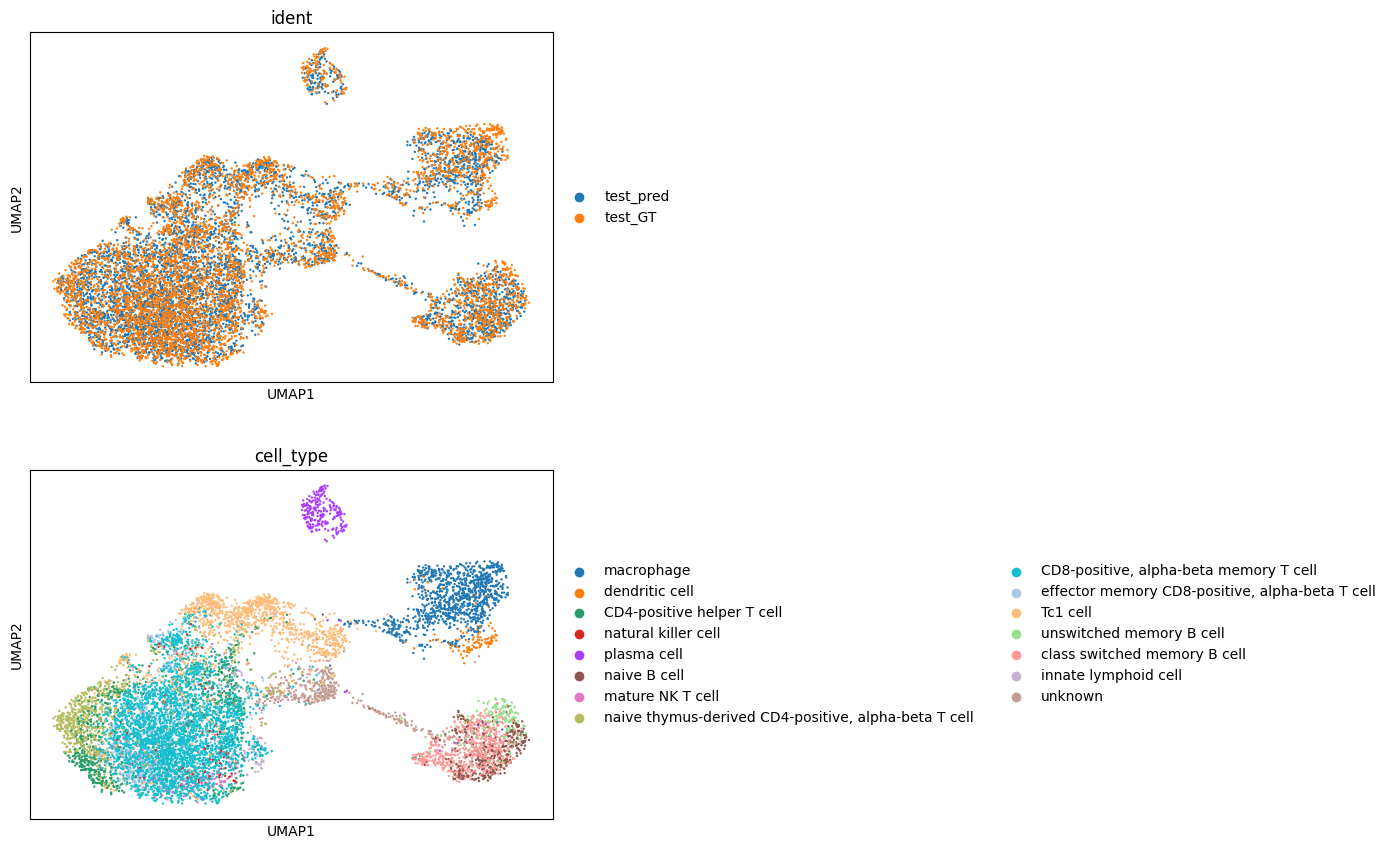

In [50]:
sc.pl.umap(sub_adata, color = ['ident','cell_type'], ncols=1)

## Intervention

In [51]:
from sklearn.metrics import roc_auc_score, roc_curve

Define helper function

In [52]:
def get_intervention(x_intervene_on, c_intervene_on, data, concept_name, concept_index, value = 1):
    # Mask ---
    mask = np.zeros_like(c_intervene_on)
    mask = torch.tensor(mask.astype(np.float32))
    
    # On ---
    inter_concepts = c_intervene_on.copy()
    inter_concepts[:,concept_index] = value
    mask[:,concept_index] = 1
    
    
    inter_concepts = torch.tensor(inter_concepts.astype(np.float32))
    inter_preds = model.intervene(torch.tensor(x_intervene_on), mask = mask, concepts= inter_concepts)
    
    x_inter_preds = inter_preds['x_pred'].detach().cpu().numpy()
  
    pred_df = pd.DataFrame(x_inter_preds,
                            index = data.obs.index,
                            columns = data.var.index,
                             )
   

    return pred_df

Test intervention on each pathway, we compare on vs. off

In [53]:
scores = dict()
curves = dict()

for pix,inter_pathway in enumerate(adata.obsm[concept_key].columns):
    
    x_inter_preds_on = get_intervention(x_intervene_on, c_intervene_on, adata_test, inter_pathway, pix, value = 1)
    x_inter_preds_off = get_intervention(x_intervene_on, c_intervene_on, adata_test, inter_pathway, pix, value = 0)

    
    # Create DataFrames
    pred_df_on = pd.DataFrame(x_inter_preds_on,
                              index = adata_test.obs.index,
                              columns = adata_test.var.index,
                             )
    
    pred_df_off = pd.DataFrame(x_inter_preds_off,
                               index = adata_test.obs.index,
                               columns = adata_test.var.index,
                              )
    
    P = adata.varm['concept_coef'].loc[:,inter_pathway]
    D = pd.Series(pred_df_on.mean(axis=0) - pred_df_off.mean(axis=0),
                         index = adata_test.var_names,
                        )
    
    scores[inter_pathway] = roc_auc_score(P,D)
    curves[inter_pathway] = roc_curve(P,D)


Convert to dataframe

In [54]:
df_auroc = pd.DataFrame(pd.Series(scores), columns = ['AUROC'])
df_auroc

,AUROC
"nuclear-transcribed mRNA catabolic process, nonsense-mediated decay",0.986354
"regulation of alternative mRNA splicing, via spliceosome",0.996675
"mRNA splicing, via spliceosome",0.951947
placenta development,0.991655
positive regulation of T cell mediated cytotoxicity,0.913300
...,...
cellular response to epidermal growth factor stimulus,0.990295
liver regeneration,0.995471
regulation of signal transduction by p53 class mediator,0.997424
proton transmembrane transport,0.951411


Get continous increase of pathway activation

In [58]:
pathway_name = 'cellular response to type II interferon'
concept_idx = adata.obsm[concept_key].columns.get_loc(pathway_name)

x_inter_preds_off = get_intervention(x_intervene_on,
                                     c_intervene_on,
                                     adata_test,
                                     pathway_name,
                                     concept_idx,
                                     value = 0)

deltas = dict()

for k,v in enumerate(np.linspace(0.1,1,5)):

    x_inter_preds_on = get_intervention(x_intervene_on,
                                        c_intervene_on,
                                        adata_test,
                                        pathway_name,
                                        concept_idx,
                                        value = v)


    # Create DataFrames
    pred_df_on = pd.DataFrame(x_inter_preds_on,
                              index = adata_test.obs.index,
                              columns = adata_test.var.index,
                             )
    
    pred_df_off = pd.DataFrame(x_inter_preds_off,
                               index = adata_test.obs.index,
                               columns = adata_test.var.index,
                              )
    
    P = adata.varm['concept_coef'].loc[:,pathway_name]
    is_P = P.index[(P == 1).values]
    D = pred_df_on.loc[:,is_P].mean(axis=1) - pred_df_off.loc[:,is_P].mean(axis=1)

    
    
    deltas[v] = D


In [62]:
display_pathways = ['T cell activation',
                    'proton transmembrane transport',
                    'cellular respiration',
                   ]

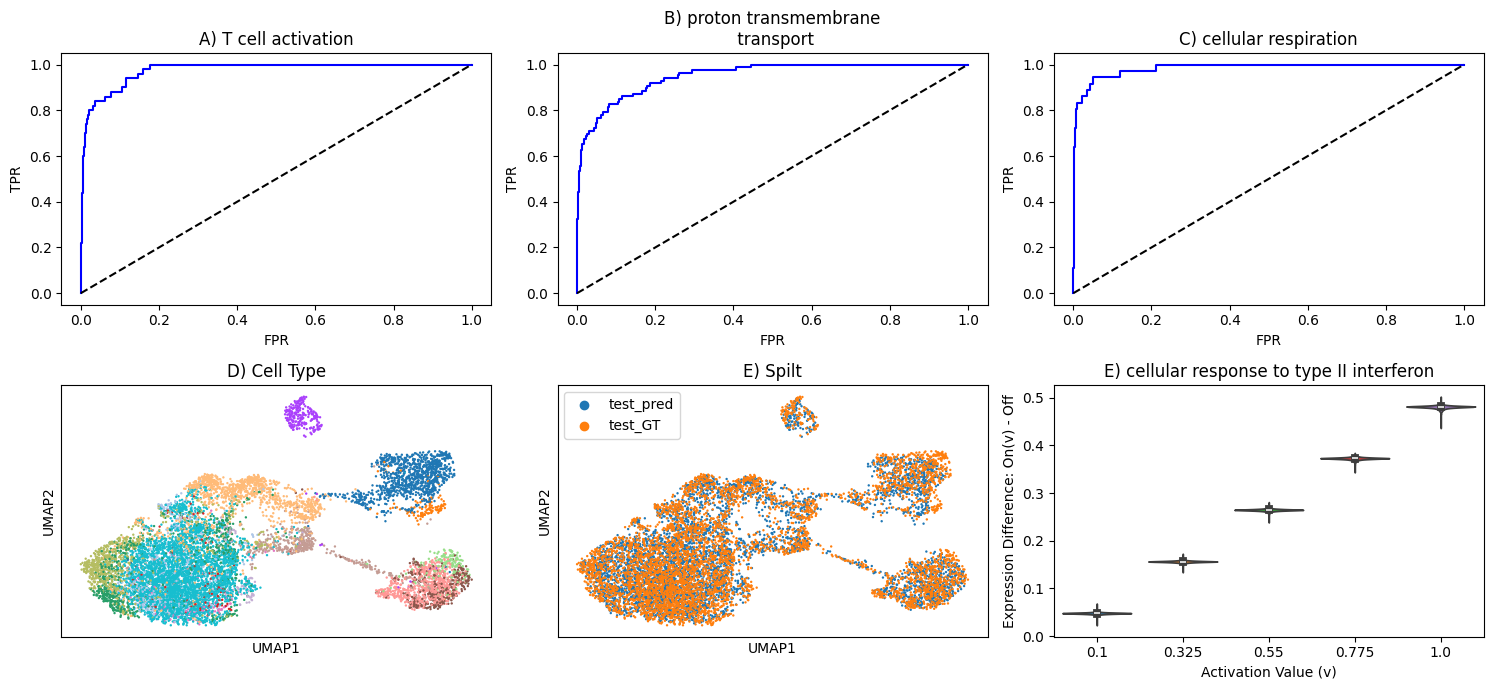

In [63]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import string

# Create a figure
fig = plt.figure(figsize=(20, 7))

gs = GridSpec(2, 4, figure=fig) 
  
letters = string.ascii_uppercase

for k,key in enumerate(display_pathways):
    if k > 3:
        break
    ax1 = fig.add_subplot(gs[0, k])
    
    ax1.plot(curves[key][0], curves[key][1], color = 'blue')
    ax1.plot([0,1],[0,1], linestyle = 'dashed', color = 'black',)
    title = '\n'.join([key[i:i+20] for i in range(0, len(key), 20)])
    ax1.set_title(letters[k] + ') ' + title)
    ax1.set_ylabel('TPR')
    ax1.set_xlabel('FPR')

ax2 = fig.add_subplot(gs[1, 0:1])  

k += 1
sc.pl.umap(sub_adata,
           color = ['cell_type'],
           ncols=1,
           ax = ax2,
           show = False,
           legend_loc = 'none',
          )

ax2.set_title(letters[k] + ') ' + 'Cell Type')


ax3 = fig.add_subplot(gs[1, 1:2])
k += 1 

sc.pl.umap(sub_adata,
           color = ['ident'],
           ncols=1,
           ax = ax3,
           show = False,
           legend_loc="upper left",
          )

ax3.set_title(letters[k] + ') ' + 'Spilt')

ax4 = fig.add_subplot(gs[1, 2])

sns.violinplot(pd.DataFrame(deltas), ax = ax4)
ax4.set_xlabel("Activation Value (v)")
ax4.set_ylabel("Expression Difference: On(v) - Off")
ax4.set_title(letters[k] + ') ' + pathway_name)

fig.tight_layout()